
## CS 601.475/675 Machine Learning Final Project
## Exploring Transfer Learning in Medical Imaging
=============================

**Contact Author:** `Harsha Mohan <harshakmohan@gmail.com>` OR `Joseph Boen <timothy.joseph.boen@gmail.com>`

**Group:** Harsha Mohan, Gurion Marks, Vincent Rizzari, Joseph Boen

Johns Hopkins University, Fall 2021

Github Repo: https://github.com/harshakmohan/ML_675_Final_Project




### Imports and Directories
First things first -- let's navigate to the right directory and get all our tools installed. 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/ML_Final_Project_UnlimitedStorage/Joseph_Analysis/

/content/drive/.shortcut-targets-by-id/1TZYbr8rrqdPuWmChRmDXJaxT3tF3L1bG/ML_Final_Project_UnlimitedStorage/Joseph_Analysis


In [3]:
from __future__ import print_function 
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.10.0+cu111
Torchvision Version:  0.11.1+cu111


In [4]:
!pip install umap-learn

     |████████████████████████████████| 86 kB 2.9 MB/s 
     |████████████████████████████████| 1.1 MB 24.9 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82709 sha256=45771f30f302fd652db2434a23d277dd8aafd0cbbfb5d7dcb6c72f3d3a88134c
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.5-py3-none-any.whl size=52603 sha256=c2e92461acfb063129b6bac7842d06bac44590608516e4de9a8a1fdfe20f749f
  Stored in directory: /root/.cache/pip/wheels/af/e9/33/04db1436df0757c42fda8ea6796d7a8586e23c85fac355f476
Successfully built umap-learn pynndescent


In [5]:
import umap
from sklearn.preprocessing import StandardScaler
from copy import deepcopy
import importlib
import skimage.io as io
import random

# Problem Description

Retinal diseases are a leading cause of blindness worldwide. Proactive treatments such as anti-vascular endothelial growth factor (anti-VEGF) medications can alleviate degeneration, and allow patients to retain useful vision. However, retinal disease must be caught early for these treatments to be effective. Optical coherence tomography (OCT) is one of the most commonly performed medical imaging methods for detecting and classifying retinal degeneration. Unfortunately, analyzing the images produced by OCT requires highly trained specialists, and diagnosis has high variability among physicians. In particular, there are four diagnosis of interest to physicians: choroidal neovascularization (CNV), diabetic macular edema (DME), drusen, or normal. CNV and DME cases require immediate anti-VEGF treatment, while drusen is less prioritized. In the figure below, the arrow marks indicate physician annotations that describe the visual characteristics of each of classes. 


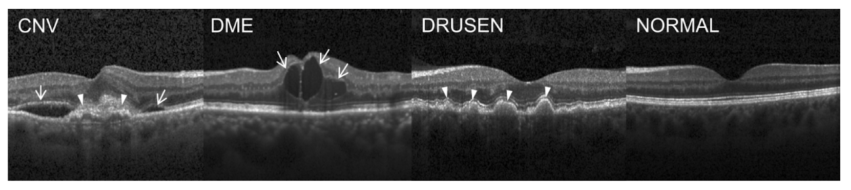

In [ ]:
annot = io.imread('Images/OCT_classes.png')
fig, ax = plt.subplots(1)
ax.imshow(annot)
ax.axis('off')
fig.set_size_inches(15,12)

# Aims

In our project, we aim to build a **deep learning algorithm to classify retinal OCT images**. The input to our convolutional neural network (CNN) will be an image, and we will output 1 of four classes. Beyond just developing a well-performing classifier, we hope to **explore the promises and limitations of transfer learning in medical imaging.** Medical imaging data is often highly specialized and scarce, which makes applying off-the-shelf deep learning tools difficult. In particular, we are interested in assesing the **effectiveness of different transfer learning strategies and data augmentations** in overcoming these challenges. 

### Data Loading and Pre-processing
We will be using a publically avaiable dataset available here: https://data.mendeley.com/datasets/rscbjbr9sj/3. 

The dataset above has a couple quirks: 
- The training set is very large and imbalanced. There are 37,206 with CNV, 11,349 with DME, 8,617 with DRUSEN, and 51,140 NORMAL.
- The validation set is balanced, there are 250 images of each class. 
- The images are not standardized. They are all 3-channel images, but they do not have the same heights and widths. 

For this quick demo, we will only load a small subset of the training set to speed up training. We will rebalance our training set so that each class has an equal number of samples, and we will apply data transformations to standardize our input images. 

In [8]:
print("Initializing Datasets and Dataloaders...")

#defining subset size. 
train_size = 256 #total training size. 
batch_size = 8 #important for training
input_size = 224 #standardizing image shape

#data location 
data_dir = "../data"

#standardizing data 
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), 
                                          data_transforms[x]) for x in ['train', 'val']}

# rebalancing training data
img_per_class = int(train_size/4)
targets = image_datasets['train'].targets
idx0 = 0
idx1 = targets.index(1)
idx2 = targets.index(2)
idx3 = targets.index(3)

idc0 = random.sample(range(idx0, idx1), img_per_class)
idc1 = random.sample(range(idx1, idx2), img_per_class)
idc2 = random.sample(range(idx2, idx3), img_per_class)
idc3 = random.sample(range(idx3, len(targets)), img_per_class)
subset_indices = idc0 + idc1 + idc2 + idc3

image_datasets['train'] = torch.utils.data.Subset(image_datasets['train'], subset_indices)
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                                   batch_size=batch_size, shuffle=True) for x in ['train', 'val']}

print('Data Loading Complete')

Initializing Datasets and Dataloaders...
Data Loading Complete


# Transfer Learning
## Model Design

In general, given data $X$ and labels $Y$ a classifier $f$ is a function that learns that mapping $f: X \to Y$. Oftentimes, learning this mapping directly can be quite difficult. In practice, most machine learning algorithms extract features from their data using another function, denoted here as $\Phi$. Thus, the classification function $f = g \circ \Phi $ is broken into a composition of functions $\Phi$ and $g$, where $g: \Phi(X) \to Y$. In our problem, $X$ are OCT images and $Y$ are classes encoded as vectors. $\Phi$ will be a convolutional neural network, which is the method of choice for image data, and $g$ will be a multi-layer perceptron. 

In this demo, we choose $\Phi$ to be a particular architecture known as a *ResNet*. ResNet's have been shown to achieve state of the art performance on computer vision benchmarks, and thus are a natural choice for feature learners. In fact, many with pre-trained trained on large datasets such as ImageNet. For our MLP, we choose a two-layer feedforward neural network with ReLU activations. Thus, we can write 
$$
f = W_2(W_1^T \Phi(X))_+
$$ where $W_2, W_1$ are the weight matrices of the MLP, $\Phi$ is the ResNet, and $(\cdot)_+$ denotes the ReLU operation. 

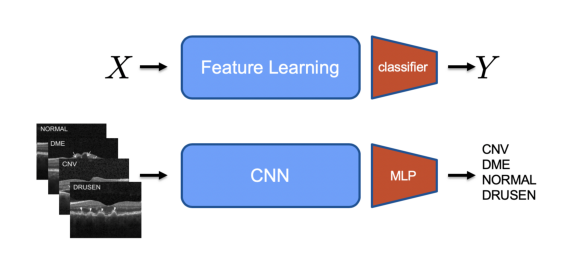

In [ ]:
architecture = io.imread('Images/Architecture.png')
fig, ax = plt.subplots(1)
ax.imshow(architecture)
ax.axis('off')
fig.set_size_inches(10,12)

## Model Training
So far we have only talked about model architectures. But what about training? In general, models are trained by learning parameters that optimize some loss function. Given loss function $\mathcal{L}$, classifier $f$ which parameters $\theta$, and training data and labels $X, Y$, this task is formalized as 
$$
\min_{\theta} \mathcal{L}(Y, f(X;\theta))
$$. 

Recall that in our case, $f = W_2(W_1^T \Phi(X))_+$

Since $\Phi$ is a ResNet, it is also a function with parameters. In fact, some can even come with pre-trained parameters after training on datasets such as ImageNet. We denote pre-trained ResNet's as $\Phi^*$. Thus, we have several choices for model training. 

In the first case, known as **feature extraction** we fix $\Phi^*$ with it's pre-trained weights, and simply optimize over the MLP $g$. That is,  
$$
\min_{W_1, W_2} \mathcal{L}(Y, W_2(W_1^T \Phi^*(X))_+)
$$. 

In the second case, known as **fine tuning**, we still initialize $\Phi$ to it's pretrained-weights, but allow ourselves to optimize over the parameters of $\Phi$ as well. That is, 
$$
\min_{W_1, W_2, \Phi} \mathcal{L}(Y, W_2(W_1^T \Phi^*(X))_+) 
$$.  


In the second case, known as **scratch**, we initialize $\Phi$ randomly, and allow ourselves to optimize over all parameters. That is, 
$$
\min_{W_1, W_2, \Phi} \mathcal{L}(Y, W_2(W_1^T \Phi(X))_+) 
$$.  

Let's see how we can do this in code. 

# Onto the Code!
### Helper Functions

In [9]:
def init_model(pretrained, feature_extracting, num_hidden, num_classes):
  '''
  stacks a 2-layer linear classifier on top of a ResNet. 
  See diagram above. 
  '''

  # feature extraction
  model = models.resnet18(pretrained=pretrained)
  set_parameter_requires_grad(model, feature_extracting = feature_extracting)
  num_ftrs = model.fc.in_features
  model.fc = nn.Sequential(nn.Linear(num_ftrs, num_hidden), nn.Linear(num_hidden, num_classes))

  return model

def set_parameter_requires_grad(model, feature_extracting):
    '''
    Turns off gradients. This helps us define what we are allowed to optimize over. 
    '''
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def get_params2update(model, feature_extracting):
    '''
    Creates a list of parameters we are allowed to update. 
    We'll need to pass this to the optimizer. 
    '''
    params_to_update = model.parameters()
    
    if feature_extracting:
      params_to_update = []
      for name,param in model.named_parameters():
          if param.requires_grad == True:
              params_to_update.append(param)
    
    return params_to_update
   
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=10):
    '''
    Pretty standard PyTorch training code. 
    '''
    since = time.time()

    val_acc_history = []
    train_acc_history = []
    
    state_dicts = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        #training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # changing model to training mode
            else:
                model.eval()   # changing model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # accumlate gradients only over train
                with torch.set_grad_enabled(phase == 'train'):

                    #predict and compute loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # metrics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                state_dicts.append(copy.deepcopy(model.state_dict()))
                
            if phase == 'train':
                train_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_acc_history, state_dicts, time_elapsed

## Defining our Models

In [10]:
# size of W_1, W_2
num_hidden = 256

# Normal, CNV, DME, Drusen
num_classes = 4

In [52]:
# feature extraction
model_fe = init_model(pretrained=True, feature_extracting=True, 
                      num_hidden=num_hidden, num_classes=num_classes)

# fine tuning
model_ft = init_model(pretrained=True, feature_extracting=False, 
                      num_hidden=num_hidden, num_classes=num_classes)

# scratch
model_s = init_model(pretrained=False, feature_extracting=False, 
                      num_hidden=num_hidden, num_classes=num_classes)

## Training

In [12]:
# GPU if we have one, CPU if not. 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [53]:
model_fe = model_fe.to(device)
params_to_update = get_params2update(model_fe, feature_extracting=True)
optimizer_fe = optim.Adam(params_to_update, lr=1e-3) #only give optimizer params we want it to update

criterion = nn.CrossEntropyLoss() #standard classification loss function

In [54]:
model_fe, val_acc_history, train_acc_history, state_dicts, time_elapsed = train_model(model_fe, 
                                          dataloaders_dict, criterion, optimizer_fe, device, num_epochs=5)

Epoch 0/4
----------
train Loss: 1.6198 Acc: 0.2891
val Loss: 1.0604 Acc: 0.5792

Epoch 1/4
----------
train Loss: 1.0567 Acc: 0.5586
val Loss: 0.8508 Acc: 0.6727

Epoch 2/4
----------
train Loss: 1.0499 Acc: 0.5469
val Loss: 0.8335 Acc: 0.6349

Epoch 3/4
----------
train Loss: 0.7931 Acc: 0.6602
val Loss: 0.7586 Acc: 0.6998

Epoch 4/4
----------
train Loss: 0.7972 Acc: 0.6602
val Loss: 0.6317 Acc: 0.7531

Training complete in 13m 35s
Best val Acc: 0.753076


In [55]:
model_ft = model_ft.to(device)
params_to_update = get_params2update(model_ft, feature_extracting=False)
optimizer_ft = optim.Adam(params_to_update, lr=1e-3) #only give optimizer params we want it to update

criterion = nn.CrossEntropyLoss() #standard classification loss function

In [56]:
model_ft, val_acc_history, train_acc_history, state_dicts, time_elapsed = train_model(model_ft, 
                                          dataloaders_dict, criterion, optimizer_ft, device, num_epochs=5)

Epoch 0/4
----------
train Loss: 1.3672 Acc: 0.4805
val Loss: 5.2306 Acc: 0.5751

Epoch 1/4
----------
train Loss: 0.9081 Acc: 0.6719
val Loss: 4.5165 Acc: 0.3445

Epoch 2/4
----------
train Loss: 0.8700 Acc: 0.6758
val Loss: 0.8764 Acc: 0.7539

Epoch 3/4
----------
train Loss: 0.6924 Acc: 0.7461
val Loss: 1.7048 Acc: 0.2075

Epoch 4/4
----------
train Loss: 0.6693 Acc: 0.7305
val Loss: 1.1393 Acc: 0.6833

Training complete in 14m 39s
Best val Acc: 0.753897


In [57]:
model_s = model_s.to(device)
params_to_update = get_params2update(model_s, feature_extracting=False)
optimizer_s = optim.Adam(params_to_update, lr=1e-3) #only give optimizer params we want it to update

criterion = nn.CrossEntropyLoss() #standard classification loss function

In [58]:
model_s, val_acc_history, train_acc_history, state_dicts, time_elapsed = train_model(model_s, 
                                          dataloaders_dict, criterion, optimizer_s, device, num_epochs=5)

Epoch 0/4
----------
train Loss: 1.6309 Acc: 0.2812
val Loss: 1.3255 Acc: 0.4840

Epoch 1/4
----------
train Loss: 1.3247 Acc: 0.3906
val Loss: 1.3927 Acc: 0.3823

Epoch 2/4
----------
train Loss: 1.1659 Acc: 0.5312
val Loss: 1.1758 Acc: 0.5037

Epoch 3/4
----------
train Loss: 0.9998 Acc: 0.5742
val Loss: 1.1948 Acc: 0.5660

Epoch 4/4
----------
train Loss: 1.1493 Acc: 0.4727
val Loss: 1.9490 Acc: 0.4487

Training complete in 14m 42s
Best val Acc: 0.566038


# Experiments
I hope the code above has been instructive. However, we can't learn much from just 3 models, 256 images is an awfully small dataset, and 5 epochs is way too short. Furthermore, we still haven't explored data augmentation! But waiting all day for models to train in just one colab notebook is no fun. Thankfully, our group managed to train a lot of models through colab pro, personal gaming GPUs, and others, so from here on out, we'll just be loading saved results and doing analysis. 

To summarize our experiments, our team trained ResNet models over:
- training types: feature extraction, fine tuning, and from scratch
- dataset sizes 256, 1024, 4096
- no data augmentation and data augmentation. 

for a total of 18 models, all of whom were trained for 30 epochs (full passes through training set), with batch size 8, Cross Entropy Loss, and Adam optimizer. 

In [13]:
# trained model directory
resnet_dir = '../Trained_Models/ResNet_Models/da={}/resnet_DA{}_TS{}_FS{}.pth'

In [ ]:
# loading results

daF_fe_best = []
daF_ft_best = []
daF_s_best = []

daT_fe_best = []
daT_ft_best = []
daT_s_best = []

for size in [256,1024,4096]:
  results = torch.load(resnet_dir.format('false','False',size,'feature_extract'), map_location=torch.device('cpu'))
  best_val = np.max(torch.stack(results['val_hist']).numpy())
  daF_fe_best.append(best_val)

  results = torch.load(resnet_dir.format('false','False',size,'fine_tune'), map_location=torch.device('cpu'))
  best_val = np.max(torch.stack(results['val_hist']).numpy())
  daF_ft_best.append(best_val)

  results = torch.load(resnet_dir.format('false','False',size,'scratch'), map_location=torch.device('cpu'))
  best_val = np.max(torch.stack(results['val_hist']).numpy())
  daF_s_best.append(best_val)

  results = torch.load(resnet_dir.format('true','True',size,'feature_extract'), map_location=torch.device('cpu'))
  best_val = np.max(torch.stack(results['val_hist']).numpy())
  daT_fe_best.append(best_val)

  results = torch.load(resnet_dir.format('true','True',size,'fine_tune'), map_location=torch.device('cpu'))
  best_val = np.max(torch.stack(results['val_hist']).numpy())
  daT_ft_best.append(best_val)

  results = torch.load(resnet_dir.format('true','True',size,'scratch'), map_location=torch.device('cpu'))
  best_val = np.max(torch.stack(results['val_hist']).numpy())
  daT_s_best.append(best_val)

# Performance Analysis

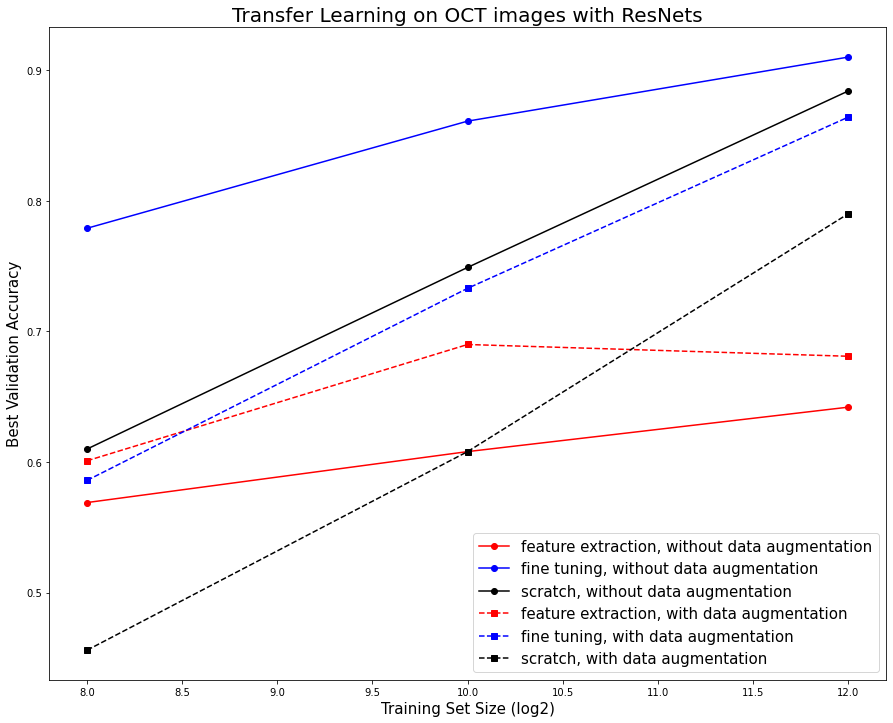

In [ ]:
size = np.array([256,1024,4096])
fig, ax = plt.subplots(1)

ax.plot(np.log2(size), daF_fe_best, 'ro-', label = 'feature extraction, without data augmentation')
ax.plot(np.log2(size), daF_ft_best, 'bo-', label = 'fine tuning, without data augmentation')
ax.plot(np.log2(size), daF_s_best, 'ko-', label = 'scratch, without data augmentation')
ax.plot(np.log2(size), daT_fe_best, 'rs--', label = 'feature extraction, with data augmentation')
ax.plot(np.log2(size), daT_ft_best, 'bs--', label = 'fine tuning, with data augmentation')
ax.plot(np.log2(size), daT_s_best, 'ks--', label = 'scratch, with data augmentation')
ax.set_xlabel('Training Set Size (log2)', fontsize = 15)
ax.set_ylabel('Best Validation Accuracy', fontsize = 15)
ax.legend(fontsize = 15)
ax.set_title('Transfer Learning on OCT images with ResNets', fontsize = 20)

fig.set_size_inches(15,12)

Let's analyze this plot above. Without data augmentation, it's pretty clear that feature extraction does the worst out of all 3 training methods, regardless of dataset size. Fine tuning starts of strong, but we can see that from scratch learning is starting to catch up as the dataset gets larger. We can reasonably extrapolate that from scratch learning might even beat fine tuning if the dataset is large enough. 

Moving onto the data augmentation case, we can see that data augmentation actually seems to hurt from scratch learning as well as fine tuning, while providing a pretty substantial boost to feature extraction. 

# A Deep Dive Into Transfer Learning

Let's explore a couple of these phenomena. We'll mainly be trying to answer two questions.  
1.  Why can fine tuning beat from scratch learning, if feature extraction doesn't? 
2.  Why is data augmentation hurting some types of training? 



### A Close Look at Neural Network Embeddings
To answer our first question, let's review what our model is 
$$
f(X) = W_2(W_1^T\Phi(X))_+
$$
This model is a composition of several operations. 
$$
X \to \phi(X) \to W_1^T\Phi(X) \to W_2(W_1^T\Phi(X))_+
$$ Let's take a look at how information flows through our model. For simplicity, let's look at the models trained without data augmentation, for training set size 1024. We want to explain testing performance, so the data and labels will be from the test set. 

### Visualization
We want to visualize a lot of things, but the dimensions aren't really going to work out. 
- $X \in \mathbb{R}^{1000 \times 3 \times 224 \times 224}$
- $\Phi(X) \in \mathbb{R}^{1000 \times 4096}$
- $W_1^T\Phi(X) \in \mathbb{R}^{1000 \times 256}$
- $W_2(W_2^T\Phi(X))_+ \in \mathbb{R}^{1000 \times 4}$

To make visualizations, we'll have to use dimensionality reduction tools such as UMAP or PCA. To avoid creating twice as many plots as we need to, we'll actually just stick to UMAP. UMAP is a dimensionality reduction tool that takes ideas from topological data analysis, and is a powerful method of visualizing non-linear data. On the other hand, PCA assumes that the dimensions are linearly correlated. This assumption is most likely not true, as nearly all the operations in this net (convolutions, max-pooling, ReLU activations) are non-linear. We actually tried using both methods, but UMAP proved to be far more instructive, so we'll dispense with PCA. 

In [15]:
# little trick to get the full dataset, so we don't have to loop over dataloaders. 
full_test = torch.utils.data.DataLoader(image_datasets['val'], batch_size=1000, shuffle=True)
X_test, Y_test = iter(full_test).next()

In [16]:
y = Y_test.numpy()

In [17]:
scaler = StandardScaler()
reducer = umap.UMAP(random_state=42)

In [ ]:
X_transform = scaler.fit_transform(torch.reshape(X_test,(1000,3*224*224)).numpy())

In [ ]:
embedding = reducer.fit_transform(X_transform)

In [18]:
class_dict = image_datasets['val'].class_to_idx
class_dict = {v: k for k, v in class_dict.items()}
class_dict

{0: 'CNV', 1: 'DME', 2: 'DRUSEN', 3: 'NORMAL'}

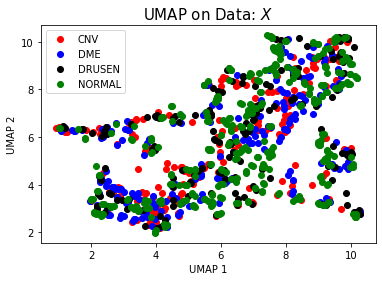

In [ ]:
for idx, color in enumerate(['ro', 'bo', 'ko', 'go']):
  plt.plot(embedding[:,0][y==idx], embedding[:,1][y==idx], color, label = class_dict[idx])
plt.legend()
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title(r'UMAP on Data: $X$', fontsize = 15)
plt.show()

Yikes! That doesn't look very nice. It's clear that this isn't an easy problem. If we just look at the pixel space, the classes are not very discernable. This is a good visualization for why we need features. 

## ResNet Embeddings
Let's look at feature space $\Phi(X)$. There's a couple tricks we'll need to use however. Remember, we trained the entire model. To visualize just the ResNet output, we'll need to do some fancy lego-block stacking in PyTorch. 

Let's start with $\Phi^*(X)$. Recall this is the output of an image passed through a ResNet pretrained on ImageNet. 

In [22]:
results = torch.load(resnet_dir.format('false','False',1024,'fine_tune'), map_location=torch.device('cpu')) #loading trained model

In [23]:
model = init_model(pretrained=True, feature_extracting=True,  
                      num_hidden=num_hidden, num_classes=num_classes)
model.load_state_dict(results['model']) #loading weights

<All keys matched successfully>

In [24]:
model1 = deepcopy(model) # a quick trick to remove the last 2 layers so we can just see the output of the ResNet
model1.fc[0] = nn.Identity() 
model1.fc[1] = nn.Identity()

In [ ]:
phi = model1.forward(X_test)

In [ ]:
phi = scaler.fit_transform(phi.numpy())

In [ ]:
phi = reducer.fit_transform(phi)

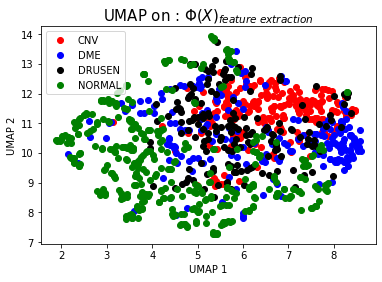

In [21]:
for idx, color in enumerate(['ro', 'bo', 'ko', 'go']):
  plt.plot(phi[:,0][y==idx], phi[:,1][y==idx], color, label = class_dict[idx])
plt.legend()
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title(r'UMAP on : $\Phi(X)_{feature\;extraction}$', fontsize = 15)
plt.show()

It's definitely better than just the raw pixel representations. But it's not really that good. There's a lot of overlap between the classes. This is actually not surprising if we think about what $\Phi^*$ is. $\Phi^*$ is a ResNet model with weights set to what it learned on ImageNet, a database of **everyday** images. These OCT images **clearly come from a different distribution**, and thus, the features generated by $\Phi^*$ won't be very applicable to this domain. 

We can show this by looking at the embeddings generated by training $\Phi$ from scratch. 

In [15]:
results = torch.load(resnet_dir.format('false','False',1024,'scratch'), map_location=torch.device('cpu'))

model = init_model(pretrained=True, feature_extracting=True, 
                      num_hidden=num_hidden, num_classes=num_classes)
model.load_state_dict(results['model'])

model1 = deepcopy(model) 
model1.fc[0] = nn.Identity() 
model1.fc[1] = nn.Identity()

In [16]:
phi = model1.forward(X_test)

In [17]:
phi = scaler.fit_transform(phi.numpy())

In [18]:
phi = reducer.fit_transform(phi)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


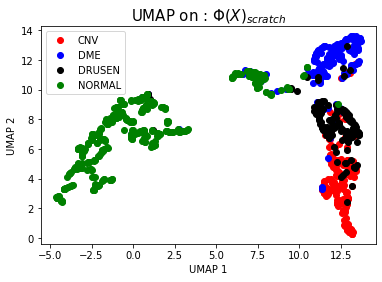

In [19]:
for idx, color in enumerate(['ro', 'bo', 'ko', 'go']):
  plt.plot(phi[:,0][y==idx], phi[:,1][y==idx], color, label = class_dict[idx])
plt.legend()
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title(r'UMAP on : $\Phi(X)_{scratch}$', fontsize = 15)
plt.show()

Much better! We can clearly see that the embeddings are working. The data is starting to separate much more clearly, and each class is definitely starting to separate out into their own clusters. But there's a lot of overlap between DRUSEN and CNV. They're almost on top of each other! But note that a ResNet (version 18 for us), has close to *11 million* parameters. That's a lot to learn from 1024 images! So we're doing a lot better than just naively picking up ImageNet weights, but it's clear that we can't really learn 11 million parameters from 1024 images. 

Let's combine the best of both worlds, in the fine-tuned model. 

In [14]:
results = torch.load(resnet_dir.format('false','False',1024,'fine_tune'), map_location=torch.device('cpu'))

model = init_model(pretrained=True, feature_extracting=True, 
                      num_hidden=num_hidden, num_classes=num_classes)
model.load_state_dict(results['model'])

model1 = deepcopy(model) 
model1.fc[0] = nn.Identity() 
model1.fc[1] = nn.Identity()

In [15]:
phi = model1.forward(X_test)

In [16]:
phi = scaler.fit_transform(phi.numpy())

In [17]:
phi = reducer.fit_transform(phi)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


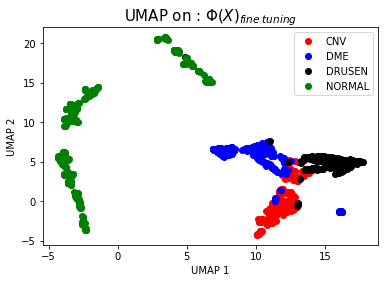

In [20]:
for idx, color in enumerate(['ro', 'bo', 'ko', 'go']):
  plt.plot(phi[:,0][y==idx], phi[:,1][y==idx], color, label = class_dict[idx])
plt.legend()
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title(r'UMAP on : $\Phi(X)_{fine\;tuning}$', fontsize = 15)
plt.show()

Amazing! The **fine-tuned** embeddings are obviously very powerful, and the classes separate out very nicely. In fact, we probably don't even need $g$, the MLP on top of the ResNet! We could probably just apply $K$-Nearest Neighbors to this model and be done. One thing that's perhaps of clinical significance, is that the normal class actually shows 3-distinct subpopulations. 

Using the same code, we can actually do the same thing for all training strategies and for all training sizes. This figure wasn't generated in this notebook (this notebook's probably too long anyways!), but we do use the same code as above, just repeated 9 times.

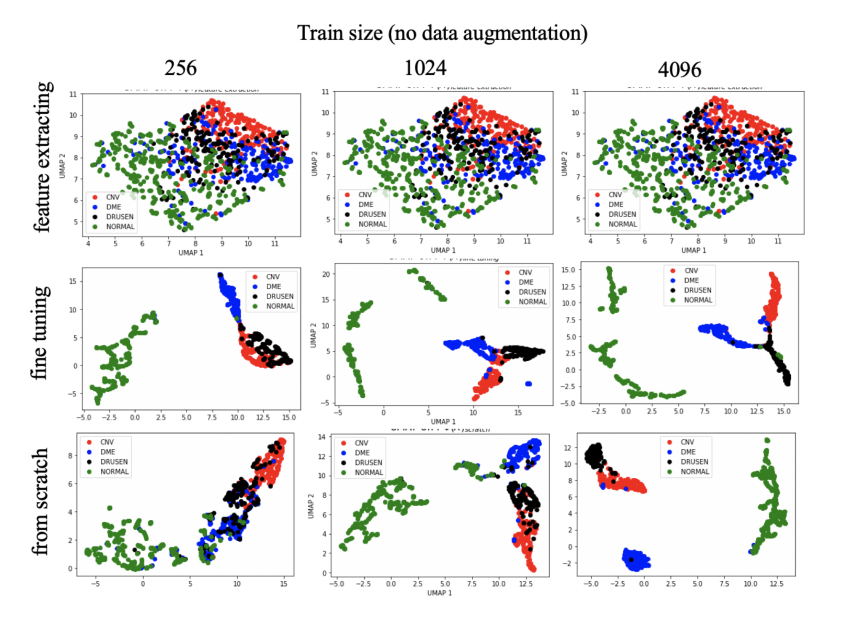

In [50]:
embeddings = io.imread('Images/Embeddings.png')
fig, ax = plt.subplots(1)
plt.imshow(embeddings)
plt.axis('off')
fig.set_size_inches(15,15)

Across the top row, we can clearly see that since we are not updating the ResNet during training, Feature Extraction will not change embeddings. 

Across the bottom row, we can see that scratch training yields fairly good features, but takes a lot of data before we get true clusters. 

In the middle row, we see the best of both worlds in Fine Tuning. 

## What does the MLP do? 

Let's do the same thing, but this time, really visualize what happens in $g$. Recall that $g: \Phi(X) \to Y$ and it simply two weights $W_1,W_2$ with a RELU sandwitched in between. 

Let's start by looking at $W_1^T \Phi(X)$. For simplicity, let's use the 1024 training data size case, and a feature extracting ResNet.

In [15]:
results = torch.load(resnet_dir.format('false','False',1024,'feature_extract'), map_location=torch.device('cpu'))

model = init_model(pretrained=True, feature_extracting=True, 
                      num_hidden=num_hidden, num_classes=num_classes)
model.load_state_dict(results['model'])

model1 = deepcopy(model) 
model1.fc[1] = nn.Identity()

In [16]:
W1_phi = model1.forward(X_test)

In [18]:
W1_phi = scaler.fit_transform(W1_phi.detach().numpy())

In [20]:
W1_phi = reducer.fit_transform(W1_phi)

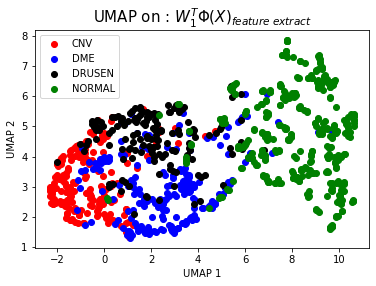

In [21]:
for idx, color in enumerate(['ro', 'bo', 'ko', 'go']):
  plt.plot(W1_phi[:,0][y==idx], W1_phi[:,1][y==idx], color, label = class_dict[idx])
plt.legend()
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title(r'UMAP on : $W_1^T \Phi(X)_{feature\;extract}$', fontsize = 15)
plt.show()

Interesting! We can see that even though the features generated by $\Phi(X)_{feature \;extract}$ (shown above) aren't very good, the first weight matrix tries valiantly to untangle the data. Let's go one further, and look at the effect of the last weight matrix $W_2$. Remember after this there are no more weights! We'll simply have to predict with what we have. 

In [13]:
results = torch.load(resnet_dir.format('false','False',1024,'feature_extract'), map_location=torch.device('cpu'))

model = init_model(pretrained=True, feature_extracting=True, 
                      num_hidden=num_hidden, num_classes=num_classes)
model.load_state_dict(results['model'])

model1 = deepcopy(model) 

In [ ]:
W2_W1_phi = model1.forward(X_test)

In [17]:
W2_W1_phi = scaler.fit_transform(W2_W1_phi.detach().numpy())

In [18]:
W2_W1_phi = reducer.fit_transform(W2_W1_phi)


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


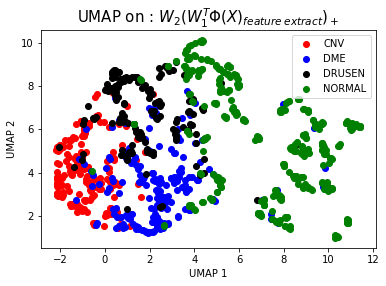

In [19]:
for idx, color in enumerate(['ro', 'bo', 'ko', 'go']):
  plt.plot(W2_W1_phi[:,0][y==idx], W2_W1_phi[:,1][y==idx], color, label = class_dict[idx])
plt.legend()
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title(r'UMAP on : $W_2(W_1^T \Phi(X)_{feature\;extract})_+$', fontsize = 15)
plt.show()

Well... not much better, but remember, we only have two layers and the initial features $\Phi(X)_{feature\;extract}$ were quite poor to begin with. Note that this visualization implies that the normal class is relatively easy to determine, whereas the other 3 abnormal diagnoses are more confounded. We can prove this using a confusion matrix.   

In [14]:
output = model1.forward(X_test)

In [16]:
 _, output = torch.max(output, 1)

In [18]:
output = output.numpy()

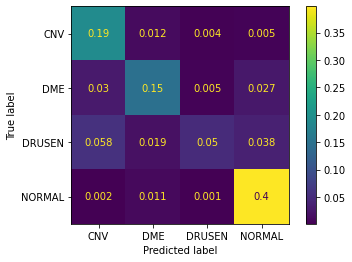

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y, output, normalize='all')
cmd = ConfusionMatrixDisplay(cm, display_labels=['CNV','DME', 'DRUSEN', 'NORMAL'])
cmd.plot()

## A Deep Dive Into Data Augmentation

We now understand why fine tuning is better than from scratch learning, which is better than feature extraction, and why scratch learning and fine tuning performance start to converge in the no-data augmentation regime. Now let's try to answer our second question, what is data augmentation hurting some of our models? 

Well, let's think about what data augmentation really is. Consider data $(X,Y) \sim p_{data}(\mathcal{X},\mathcal{Y})$. When we augment data, we rimplicity hope that we are drawing from the same distribution, and our augmenations should not alter the labels. That is, if $\tilde{X}$ is augmented $X$ data, we hope that $(\tilde{X},Y) \sim p_{data}(\mathcal{X},\mathcal{Y})$. But we can clearly see that $\tilde{X}$ is hurting our models performance. Why is this? 

Well one theory would be that our data augmentations are actually altering the semantic content of our data! $(\tilde{X},Y) \nsim p_{data}(\mathcal{X},\mathcal{Y})$!

How can we test this? Well, we can't explicitly compute the lilklihood $\mathcal{L}_{p_{data}}(\tilde{X}, Y)$ since we don't know $p_{data}$. But we do know $p(Y \mid X)$, that's our classifier! 

So what we can do is calculate $p(Y \mid \tilde{X})$ and compare it to $p(Y \mid X)$. If the data augmentations are not changing the semantic content of these images, these should be the same. How do we do this in code? Well we simply pick our best classifier, and visualize its predictions on $X$ and $\tilde{X}$. Read on to see the implementation!


In [ ]:
#our best model, see accuracy graph 
results = torch.load(resnet_dir.format('false','False',4096,'fine_tune'), map_location=torch.device('cpu'))

model = init_model(pretrained=True, feature_extracting=True, 
                      num_hidden=num_hidden, num_classes=num_classes)
model.load_state_dict(results['model'])

model1 = deepcopy(model) 

In [21]:
output = model1.forward(X_test)

In [20]:
import pickle as pk

In [23]:
output = output.detach().numpy()

In [24]:
pk.dump(output, open('DAfalse_4096ft_output.pk', 'wb'))

In [25]:
#getting augmented data
print("Initializing Augmented Datasets and Dataloaders...")

#defining subset size. 
train_size = 256 #total training size. 
batch_size = 8 #important for training
input_size = 224 #standardizing image shape

#data location 
data_dir = "../data"

#new data transform! During training we actually didn't 
#augment the validation data, but to explain test performance, we will here. 
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Create training and validation datasets
image_datasets_aug = {x: datasets.ImageFolder(os.path.join(data_dir, x), 
                                          data_transforms[x]) for x in ['train', 'val']}

# rebalancing training data
img_per_class = int(train_size/4)
targets = image_datasets_aug['train'].targets
idx0 = 0
idx1 = targets.index(1)
idx2 = targets.index(2)
idx3 = targets.index(3)

idc0 = random.sample(range(idx0, idx1), img_per_class)
idc1 = random.sample(range(idx1, idx2), img_per_class)
idc2 = random.sample(range(idx2, idx3), img_per_class)
idc3 = random.sample(range(idx3, len(targets)), img_per_class)
subset_indices = idc0 + idc1 + idc2 + idc3

image_datasets_aug['train'] = torch.utils.data.Subset(image_datasets_aug['train'], subset_indices)
dataloaders_dict_aug = {x: torch.utils.data.DataLoader(image_datasets_aug[x], 
                                                   batch_size=batch_size, shuffle=True) for x in ['train', 'val']}

print('Augmented Data Loading Complete')

Initializing Augmented Datasets and Dataloaders...
Augmented Data Loading Complete


In [26]:
# little trick to get the full dataset, so we don't have to loop over dataloaders. 
full_test_aug = torch.utils.data.DataLoader(image_datasets_aug['val'], batch_size=1000, shuffle=True)
X_test_aug, Y_test_aug = iter(full_test_aug).next()

In [40]:
Y_test_aug = Y_test_aug.numpy()

In [27]:
output = model1.forward(X_test_aug)

In [28]:
output = output.detach().numpy()

In [29]:
pk.dump(output, open('DAtrue_4096ft_output.pk', 'wb'))

In [30]:
output = pk.load(open('DAfalse_4096ft_output.pk', 'rb'))

In [31]:
output_aug = pk.load(open('DAtrue_4096ft_output.pk', 'rb'))

In [34]:
combined = np.concatenate((output, output_aug), axis = 0)

In [41]:
combined_y = np.concatenate((Y_test, Y_test_aug), axis = 0)

In [42]:
combined_results = {'X': combined, 'Y': combined_y}

In [43]:
pk.dump(combined_results, open('combined_output.pk', 'wb'))

In [38]:
combined = scaler.fit_transform(combined)

In [39]:
embedding = reducer.fit_transform(combined)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


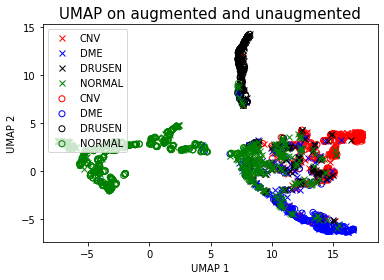

In [48]:
for idx, color in enumerate(['r', 'b', 'k', 'g']):
  plt.scatter(embedding[:1000,0][combined_y[:1000]==idx], embedding[:1000,1][combined_y[:1000]==idx], 
           edgecolor = color, label = class_dict[idx], facecolors = 'none')
for idx, color in enumerate(['rx', 'bx', 'kx', 'gx']):
  plt.plot(embedding[1000:,0][combined_y[1000:]==idx], embedding[1000:,1][combined_y[1000:]==idx], 
           color, label = class_dict[idx])
plt.legend()
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title(r'UMAP on augmented and unaugmented', fontsize = 15)
plt.show()

And look! The circles indicate predictions from unaugmented data, while the crosses indicate predictions from augmented data. We can clearly see that $p(Y \mid X) \neq p(Y \mid \tilde{X})$. In fact, it's quite clear that some augmented normal images are actually being classified as pathological (e.g. DME, CNV, DRUSEN). This clearly shows that data augmentations are changing the meaning of our images!

# Conclusion

We hope that this exploration has been fruitful. To summarize, we wanted to explore the opportunities and limitations of transfer learning on medical imaging datasets. We found promising performance, but we were very intrigued at two trends in the data: 

1. Fine Tuning did better than Scratch Learning, and Scratch Learning did better than Feature Extraction
2. Data Augmentation actually hurt some of our models. 

Using a variety of visualizations, we explained why. 

1. Feature Extraction is poor because ResNets trained on ImageNet do not yeild directly transferable features to OCT images. Scratch Learning is better but data intensive. ResNets have 11 million parameters. Fine Tuning combines the best of both worlds. 
2. If we are not careful, data augmentation can actually change the semantic content of images, leading us to train on completely different distributions. 

This has been an enjoyable class and final project, and we certainly learned a lot through our work. We hope dear reader, that you did too!